In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec

from utils import *
from utilsPCA import *
from plotting import *
from efficiency import *
from isolation import *

import matplotlib as mpl

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('axes', labelsize=16, titlesize=20)
mpl.rcParams["legend.title_fontsize"]=18

#plt.style.use(hep.style.CMS)
%matplotlib inline

In [2]:
C = 29.9792458 #cm/ns

def distance(x1,y1,z1,x2,y2,z2):
    return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5

In [3]:
# returns res that contains the parameters, the chi squared and 
# the counts and bins used to plot the data
def gauss_fit(data, init_parms, bins=300):
    hist, nbins = np.histogram(data, bins=bins)
    nbins = 0.5 * (bins[1:] + bins[:-1])
    errors = [np.sqrt(oh+1) for oh in hist]
    init_parameters = init_parms
    cost_func = cost.LeastSquares(nbins, hist, errors, model)
    min_obj = Minuit(cost_func, *init_parameters)
    res = min_obj.migrad()
    chi2 = min_obj.fval/(len(nbins[:-1])-3)
    return res, chi2, hist, nbins[:-1]

#same as above but plots also the data
def gauss_fit_and_plot(data, init_parms, label="data", colors=["midnightblue","dodgerblue"], bins=300):
    res, chi2, hists, newbins = gauss_fit(data, init_parms, bins=bins)
    y = model(newbins, *res.values)
    plt.plot(newbins, y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', color=colors[0], linewidth=2)
    plt.hist(np.array(data), bins=bins, color=colors[1], alpha=0.7)
    plt.legend(fontsize=16)
    plt.grid()
    return res, chi2

In [4]:
# quick plot with list, np array or flattened awkward array
def myhist(X, bins=30, title='title', xlabel='time (ns)', ylabel='Counts / bin', color='dodgerblue', alpha=1, fill='stepfilled', range=None, label="data"):
    #plt.figure(dpi=100)
    if range==None:
        plt.hist(np.array(X), bins=bins, color=color, alpha=alpha, histtype=fill, label=label)
    else:
        plt.hist(np.array(X), bins=bins, color=color, alpha=alpha, histtype=fill, range=range, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()  

In [71]:
import os
os.listdir("new_root_files/D99")

['histo_200pt_newMuCut.root', 'histo_200pt_oldMuCut.root', 'histov4.root']

In [73]:
filename = 'new_root_files/D99/histo_200pt_newMuCut.root'
file = uproot.open(filename)

In [74]:
file.keys()

['ticlDumper;1',
 'ticlDumper/tracksters;1',
 'ticlDumper/clusters;1',
 'ticlDumper/candidates;1',
 'ticlDumper/trackstersMerged;1',
 'ticlDumper/associations;1',
 'ticlDumper/simtrackstersSC;1',
 'ticlDumper/simtrackstersCP;1',
 'ticlDumper/tracks;1',
 'ticlDumper/simTICLCandidate;1']

In [75]:
# filename2 = 'new_root_files/histo_100pi_path.root'
# file2 = uproot.open(filename2)
# TICLCandidate2 = file2["ticlDumper/candidates"]
# simTICLCandidate2 = file2["ticlDumper/simTICLCandidate"]
# candidate_time2          = TICLCandidate2["candidate_time"].array()
# candidate_timeErr2       = TICLCandidate2["candidate_timeErr"].array()

In [76]:
simtrackstersSC = file["ticlDumper/simtrackstersSC"]
simtrackstersCP = file["ticlDumper/simtrackstersCP"]
tracksters  = file["ticlDumper/tracksters"]
trackstersMerged = file["ticlDumper/trackstersMerged"]
associations = file["ticlDumper/associations"]
tracks = file["ticlDumper/tracks"]
simTICLCandidate = file["ticlDumper/simTICLCandidate"]
TICLCandidate = file["ticlDumper/candidates"]
clusters = file["ticlDumper/clusters"]

In [77]:
TICLCandidate.keys()

['NCandidates',
 'candidate_charge',
 'candidate_pdgId',
 'candidate_id_probabilities',
 'candidate_time',
 'candidate_timeErr',
 'candidate_energy',
 'candidate_raw_energy',
 'candidate_px',
 'candidate_py',
 'candidate_pz',
 'track_in_candidate',
 'tracksters_in_candidate']

In [78]:
simTICLCandidate_simTracksterCPIndex = simTICLCandidate['simTICLCandidate_simTracksterCPIndex'].array()
simTICLCandidate_pdgId = simTICLCandidate['simTICLCandidate_pdgId'].array()
candidate_pdgId = TICLCandidate["candidate_pdgId"].array()
simTICLCandidate_charge = simTICLCandidate['simTICLCandidate_charge'].array()

In [79]:
track_pt = tracks["track_pt"].array()
track_id = tracks["track_id"].array()
track_hgcal_eta = tracks["track_hgcal_eta"].array()
track_hgcal_pt = tracks["track_hgcal_pt"].array()
track_missing_outer_hits = tracks["track_missing_outer_hits"].array()
# track_missing_inner_hits = tracks["track_missing_inner_hits"].array()
track_nhits = tracks["track_nhits"].array()
track_quality = tracks["track_quality"].array()
track_time_mtd_err = tracks["track_time_mtd_err"].array()
track_isMuon = tracks["track_isMuon"].array()
track_isTrackerMuon = tracks["track_isTrackerMuon"].array()

# track_boundaryX = simtrackstersSC["track_boundaryX"].array()
# track_boundaryY = simtrackstersSC["track_boundaryY"].array()
# track_boundaryZ = simtrackstersSC["track_boundaryZ"].array()

In [84]:
denom = []
ismuon = []
isTkmuon = []
isboth = []
isNone = []
isNotMuon = []
for ev in range(len(track_pt)):
    for pt, muon, tkMuon in zip(track_pt[ev], track_isMuon[ev], track_isTrackerMuon[ev]):
        if pt > 300:
            continue
        denom.append(pt)
        if muon == -1:
            isNotMuon.append(pt)
        elif muon==1 and tkMuon==0:
            ismuon.append(pt)
        elif tkMuon==1 and muon == 0:
            isTkmuon.append(pt)
        elif muon==1 and tkMuon==1:
            isboth.append(pt)
        elif muon==0 and tkMuon==0:    
            isNone.append(pt)

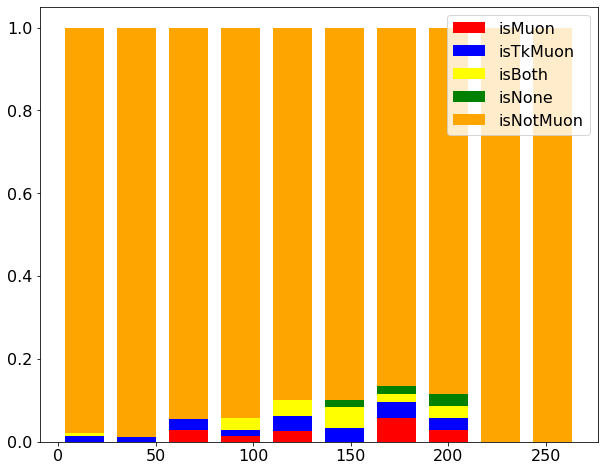

In [85]:
den_h, bins = np.histogram(denom, bins=10)
isNotMuon_h, _ = np.histogram(isNotMuon, bins=bins)
ismuon_h, _ = np.histogram(ismuon, bins=bins)
isTkmuon_h, _ = np.histogram(isTkmuon, bins=bins)
isboth_h, _ = np.histogram(isboth, bins=bins)
isNone_h, _ = np.histogram(isNone, bins=bins)
plt.figure(figsize=(10,8))
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.bar(bin_centers, ismuon_h/den_h,width=20, color="red")
plt.bar(bin_centers, isTkmuon_h/den_h, bottom=ismuon_h/den_h,width=20, color="blue")
plt.bar(bin_centers, isboth_h/den_h, bottom=ismuon_h/den_h+isTkmuon_h/den_h,width=20, color="yellow")
plt.bar(bin_centers, isNone_h/den_h, bottom=ismuon_h/den_h+isTkmuon_h/den_h+isboth_h/den_h,width=20, color="green")
plt.bar(bin_centers, isNotMuon_h/den_h, bottom=ismuon_h/den_h+isTkmuon_h/den_h+isboth_h/den_h+isNone_h/den_h, width=20, color="orange")
plt.legend(["isMuon", "isTkMuon", "isBoth", "isNone", "isNotMuon"], fontsize=16)

In [86]:
isNotMuon_h

array([133,  94,  68,  66,  71,  53,  45,  31,   3,   2])

In [87]:
simTICLCandidate_time = simTICLCandidate['simTICLCandidate_time'].array()
simTICLCandidate_raw_energy = simTICLCandidate['simTICLCandidate_raw_energy'].array()
simTICLCandidate_regressed_energy = simTICLCandidate['simTICLCandidate_regressed_energy'].array()
simTICLCandidate_track_in_candidate = simTICLCandidate['simTICLCandidate_track_in_candidate'].array()

In [88]:
candidate_pdgId         = TICLCandidate["candidate_pdgId"].array()
# candidate_id_prob       = TICLCandidate["candidate_id_probabilities"].array()
tracksters_in_candidate = TICLCandidate["tracksters_in_candidate"].array()
track_in_candidate      = TICLCandidate["track_in_candidate"].array()
# candidate_energy        = TICLCandidate["candidate_energy"].array()
candidate_raw_energy        = TICLCandidate["candidate_raw_energy"].array()
# candidate_time          = TICLCandidate["candidate_time"].array()
# candidate_timeErr       = TICLCandidate["candidate_timeErr"].array()
#NCandidates   = TICLCandidate["NCandidates"]
tracsktersMerged_rawEne       = trackstersMerged["raw_energy"].array()

In [89]:
# recoToSim_en    = associations["Mergetstracksters_recoToSim_SC_sharedE"].array()
# recoToSim_score = associations["Mergetstracksters_recoToSim_SC_score"].array()
# recoToSim_index = associations["Mergetstracksters_recoToSim_SC"].array()

simToReco_en    = associations["Mergetstracksters_simToReco_SC_sharedE"].array()
simToReco_score = associations["Mergetstracksters_simToReco_SC_score"].array()
simToReco_index = associations["Mergetstracksters_simToReco_SC"].array()

In [90]:
#tracksters_vt        = tracksters["vertices_time"].array()

In [91]:
SC_boundx        = simtrackstersSC["boundaryX"].array()
SC_boundy        = simtrackstersSC["boundaryY"].array()
SC_boundz        = simtrackstersSC["boundaryZ"].array()
SC_bx            = simtrackstersSC["barycenter_x"].array()
SC_by            = simtrackstersSC["barycenter_y"].array()
SC_bz            = simtrackstersSC["barycenter_z"].array()
SC_boundary_time     = simtrackstersSC["timeBoundary"].array()
SC_CALO_time     = simtrackstersSC["time"].array()
SC_CALO_timeErr      = simtrackstersSC["timeError"].array()
SC_trackIdx      = simtrackstersSC["trackIdx"].array()

In [92]:
CP_boundx        = simtrackstersCP["boundaryX"].array()
CP_boundy        = simtrackstersCP["boundaryY"].array()
CP_boundz        = simtrackstersCP["boundaryZ"].array()
CP_bx            = simtrackstersCP["barycenter_x"].array()
CP_by            = simtrackstersCP["barycenter_y"].array()
CP_bz            = simtrackstersCP["barycenter_z"].array()
CP_CALO_time     = simtrackstersCP["time"].array()
CP_boundary_time     = simtrackstersCP["timeBoundary"].array()
CP_CALO_timeErr      = simtrackstersCP["timeError"].array()
CP_trackIdx      = simtrackstersCP["trackIdx"].array()

In [31]:
ticlv5_ncandidates = ak.count(candidate_pdgId, axis=1) / ak.count(SC_trackIdx, axis=1)

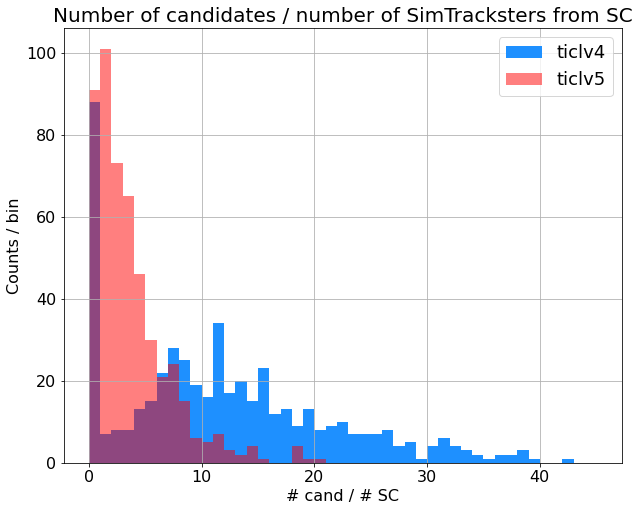

In [56]:
plt.figure(figsize=(10, 8))
# plt.xlim(-100, 6500)
myhist(ak.count(candidate_pdgId, axis=1) / ak.count(SC_trackIdx, axis=1), title= "Candidate raw energy", xlabel="# cand / # SC", ylabel = "Counts / bin", bins = 45, label="ticlv4", range=(0,45))
myhist(ticlv5_ncandidates, title= "Number of candidates / number of SimTracksters from SC", xlabel="# cand / # SC", ylabel = "Counts / bin", bins = 45, color="red", alpha=0.5, label="ticlv5", range=(0,45))
plt.legend(fontsize=18)
plt.grid()
plt.show()

In [26]:
ticlv5_raw_energy = ak.flatten(candidate_raw_energy)[ak.flatten(candidate_raw_energy)<3000]

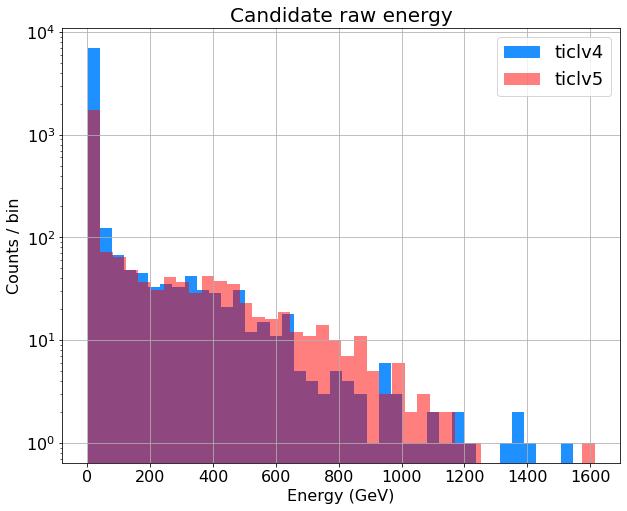

In [57]:
plt.figure(figsize=(10, 8))
plt.yscale("log")
# plt.xlim(-100, 6500)
myhist(ak.flatten(candidate_raw_energy)[ak.flatten(candidate_raw_energy)<3000], title= "Candidate raw energy", xlabel="Energy (GeV)", ylabel = "Counts / bin", bins = 40, label="ticlv4")
myhist(ticlv5_raw_energy, title= "Candidate raw energy", xlabel="Energy (GeV)", ylabel = "Counts / bin", bins = 40, color="red", alpha=0.5, label="ticlv5")
plt.legend(fontsize=18)
plt.grid()
plt.show()

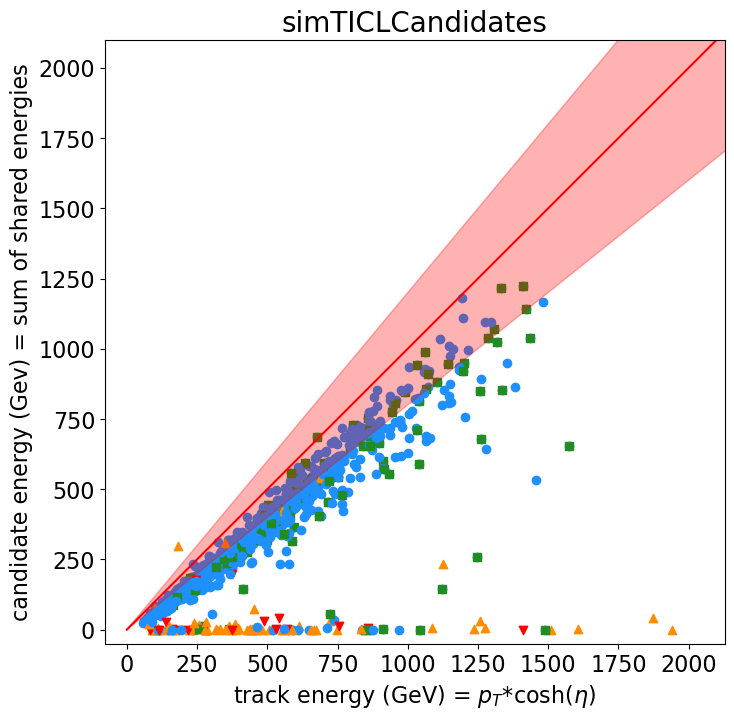

In [202]:
plt.figure(figsize=(8,8), dpi=100)
for tk_in_cand, cand_ene, cand_raw_ene, s2r_ene, trk_pt, trk_eta, trk_id, trk_miss, trk_nhits in zip(simTICLCandidate_track_in_candidate, simTICLCandidate_regressed_energy, simTICLCandidate_raw_energy, simToReco_en, track_pt, track_hgcal_eta, track_id, track_missing_outer_hits, track_nhits):
    for i, tk in enumerate(tk_in_cand):
        if tk != -1:
            idx = np.where(trk_id==tk)[0][0]
            pt = trk_pt[idx]
            eta = trk_eta[idx]
            missing = trk_miss[idx]
#             print(s2r_ene[0], ak.sum(s2r_ene[0]))
            energy = ak.sum(s2r_ene[0]) #cand_ene[i] #cand_raw_ene[i] #
#             if pt*np.cosh(eta) > 3000:
#                 continue
            if not missing:
                plt.scatter(pt*np.cosh(eta), energy, c="dodgerblue")
#                 if pt*np.cosh(eta) / energy > 1.2 or pt*np.cosh(eta) / energy < 0.8:
#                     print(pt, eta, pt*np.cosh(eta) , cand_ene[i], energy, trk_nhits[idx] )
                if trk_nhits[idx] <= 15:
                    plt.scatter(pt*np.cosh(eta), energy, c="forestgreen", marker="s")
            elif missing < 5:
                plt.scatter(pt*np.cosh(eta), energy, c="darkorange", marker = "^")
            else:
                plt.scatter(pt*np.cosh(eta), energy, c="red", marker = "v")
plt.xlabel("track energy (GeV) = $p_T$*cosh($\eta$)")
plt.ylabel("candidate energy (Gev) = sum of shared energies") # sum of LCs = raw  #CP energy") #
x = np.linspace(0,5000,100)
plt.plot(x, x, c="red")
plt.fill_between(x, x*0.8, x*1.2, color="red", alpha = 0.3)
plt.title("simTICLCandidates")
plt.axis("equal")
plt.xlim(-50,2100)
plt.ylim(-50,2100)
plt.show()

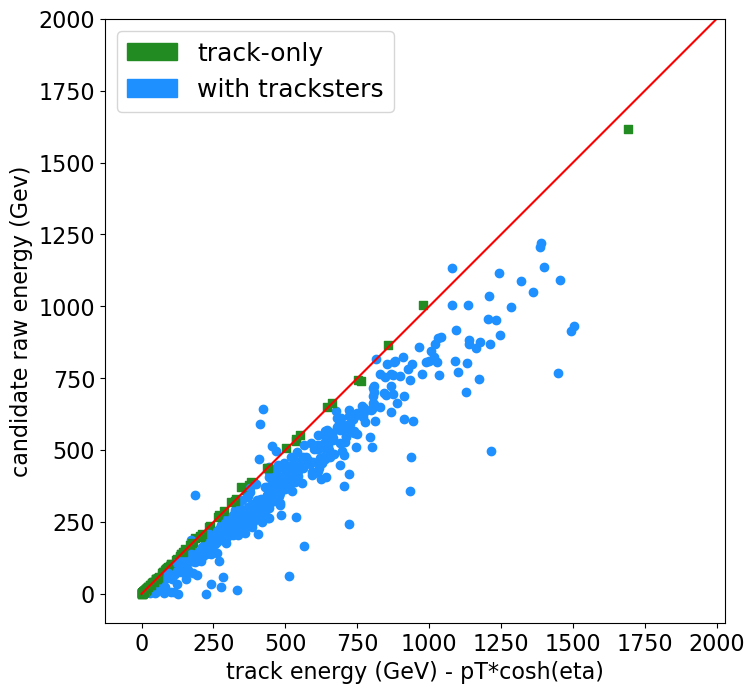

In [93]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8,8), dpi=100)
empty = [0,0]
with_ts = [0,0]
for tk_in_cand, ts_in_cand, cand_ene, trk_pt, trk_eta, trk_id in zip(track_in_candidate, tracksters_in_candidate, candidate_raw_energy, track_hgcal_pt,track_hgcal_eta, track_id):
    for i, tk in enumerate(tk_in_cand):
        if tk != -1:
            try:
                idx = np.where(trk_id==tk)[0][0]
            except:
                continue
            pt = trk_pt[idx]
            eta = trk_eta[idx]
            if len(ts_in_cand[i])== 0:
                # print("empty: ", pt*np.cosh(eta), cand_ene[i])
                plt.scatter(pt*np.cosh(eta), cand_ene[i], c="forestgreen", marker="s")
#                 empty = [pt*np.cosh(eta), cand_ene[i]]
            else:
                plt.scatter(pt*np.cosh(eta), cand_ene[i], c="dodgerblue")
#                 with_ts = [pt*np.cosh(eta), cand_ene[i]]
            # if pt*np.cosh(eta) / cand_ene[i] > 10 or pt*np.cosh(eta) / cand_ene[i] < 0.1:
            #     print("huge difference: ", pt*np.cosh(eta), cand_ene[i])
plt.xlabel("track energy (GeV) - pT*cosh(eta)")
plt.ylabel("candidate raw energy (Gev)")
x = np.linspace(0,3000,100)
plt.plot(x, x, c="red")
plt.axis("equal")
red_patch = mpatches.Patch(color='forestgreen', label='track-only')
blue_patch = mpatches.Patch(color='dodgerblue', label='with tracksters')
plt.legend(handles=[red_patch,blue_patch], loc= "upper left", fontsize=18)
plt.ylim(-100,2000)
plt.xlim(-100,2000)
plt.show()

In [94]:
#colors = ["red", "yellow", "forestgreen", "dodgerblue", "blue", "grey", "grey", "grey", "grey", "grey"]
colors = ["red", "darkorange", "yellow", "forestgreen", "dodgerblue", "blue", "violet", "pink"]
alphas = [0.4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
marker = ["o", "s", "s", "s"]

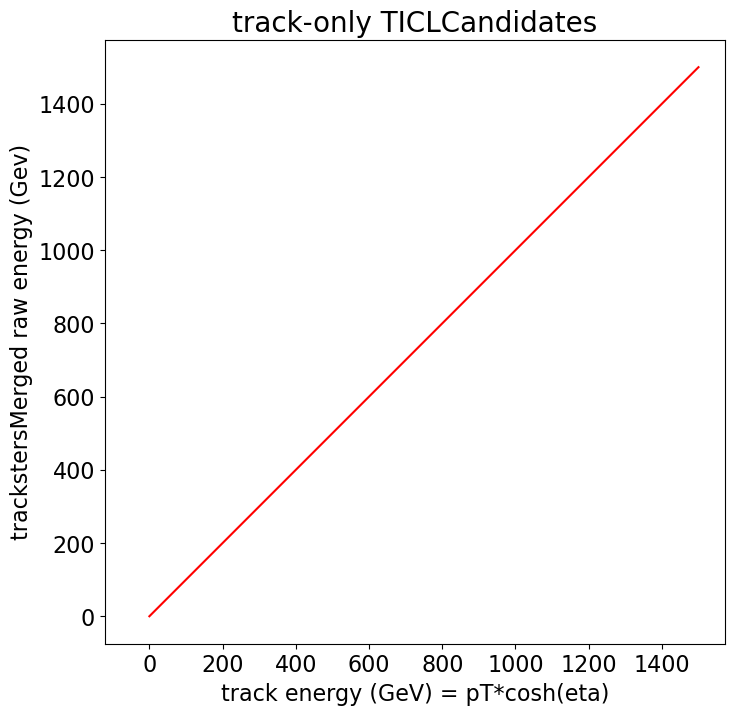

In [95]:
import matplotlib.patches as mpatches

counts = np.zeros(5)
plt.figure(figsize=(8,8), dpi=100)
ev =0
for tk_in_simCand, tkM_rawEne, tk_in_cand, ts_in_cand, trk_pt, trk_eta, trk_id, trk_miss_out, trk_nhits, trk_qual in zip(simTICLCandidate_track_in_candidate, tracsktersMerged_rawEne, track_in_candidate, tracksters_in_candidate, track_hgcal_pt,track_hgcal_eta, track_id, track_missing_outer_hits, track_nhits, track_quality):
#     print("--- event ---",ev+1)
    ev+=1
    link = False
    for i, tk in enumerate(tk_in_cand):
        if tk != -1:
            try:
                idx = np.where(trk_id==tk)[0][0]
            except:
                continue
            pt = trk_pt[idx]
            eta = trk_eta[idx]
            missing_out = trk_miss_out[idx]
#             missing_inn = trk_miss_inn[idx]
            nhits = trk_nhits[idx]
            if len(ts_in_cand[i])== 0 and not missing_out and tk_in_simCand[0]!=-1:
                plt.scatter(pt*np.cosh(eta), ak.max(tkM_rawEne), c="red", alpha=alphas[0], marker=marker[0]) #c=colors[missing_inn],
#                 plt.text(pt*np.cosh(eta), ak.sum(tkM_rawEne), ev)
#                 print(ev, pt, pt*np.cosh(eta), eta, trk_qual[idx])
#                 if pt*np.cosh(eta) / ak.sum(tkM_rawEne) < 0.3:
#                     print(pt*np.cosh(eta), ak.sum(tkM_rawEne), pt , eta, nhits)
#                 plt.scatter(pt*np.cosh(eta), cand_ene[i], c=colors[missing], alpha=alphas[missing], marker=marker[nhits//15])
#                 counts[missing_inn] += 1
            if len(ts_in_cand[i])!= 0:
                link = True
#     if not link:
#         print("no link with track")
#             else:
#                 plt.scatter(pt*np.cosh(eta), cand_ene[i], c=colors[missing], alpha=alphas[missing], marker=marker[nhits//15])
    if ev==10:
        break
plt.xlabel("track energy (GeV) = pT*cosh(eta)")
plt.ylabel("trackstersMerged raw energy (Gev)")
x = np.linspace(0,1500,100)
plt.plot(x, x, c="red")
plt.axis("equal")
plt.title("track-only TICLCandidates")
# patches = []
# for i, (count, color) in enumerate(zip(counts, colors)):
# #     patches.append(mpatches.Patch(color=color, label=str(i*4) +'-'+ str((i+1)*4-1) + ' hits (' + str(int(count)) + ')'))
#     patches.append(mpatches.Patch(color=color, label=str(i) + ' missing hits (' + str(int(count)) + ')'))
# plt.legend(handles=patches, loc= "lower right")
plt.xlim(-50,1500)
plt.show()

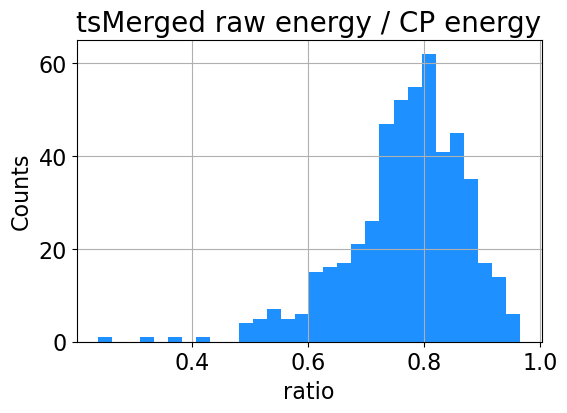

In [131]:
# simTICLCandidate_regressed_energy # CP energy
hist(ak.sum(tracsktersMerged_rawEne, axis=1) / simTICLCandidate_regressed_energy, title="tsMerged raw energy / CP energy", xlabel="ratio")

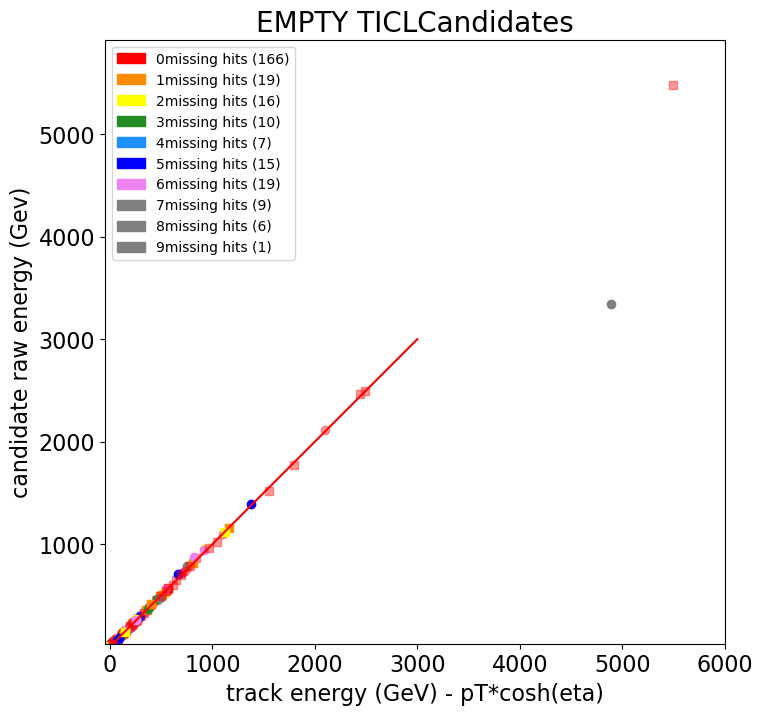

In [77]:
import matplotlib.patches as mpatches

colors = ["red", "darkorange", "yellow", "forestgreen", "dodgerblue", "blue", "violet", "grey", "grey", "grey", "grey"]
counts = np.zeros(10)
plt.figure(figsize=(8,8), dpi=100)
# empty = [0,0]
# with_ts = [0,0]
for tk_in_cand, ts_in_cand, cand_ene, trk_pt, trk_eta, trk_id, trk_miss, trk_nhits in zip(track_in_candidate, tracksters_in_candidate, candidate_raw_energy, track_hgcal_pt,track_hgcal_eta, track_id, track_missing_outer_hits, track_nhits):
    for i, tk in enumerate(tk_in_cand):
        if tk != -1:
            try:
                idx = np.where(trk_id==tk)[0][0]
            except:
                continue
            pt = trk_pt[idx]
            eta = trk_eta[idx]
            missing = trk_miss[idx]
            nhits = trk_nhits[idx]
            if len(ts_in_cand[i])== 0:
                #plt.scatter(pt*np.cosh(eta), missing, c=colors[nhits//4], alpha=alphas[nhits//4])
                plt.scatter(pt*np.cosh(eta), cand_ene[i], c=colors[missing], alpha=alphas[missing], marker=marker[nhits//15])
                counts[missing] += 1
#             else:
#                 plt.scatter(pt*np.cosh(eta), cand_ene[i], c=colors[missing], alpha=alphas[missing], marker=marker[nhits//15])
plt.xlabel("track energy (GeV) - pT*cosh(eta)")
plt.ylabel("candidate raw energy (Gev)")
x = np.linspace(0,3000,100)
plt.plot(x, x, c="red")
plt.axis("equal")
plt.title("EMPTY TICLCandidates")
patches = []
for i, (count, color) in enumerate(zip(counts, colors)):
    patches.append(mpatches.Patch(color=color, label=str(i) + 'missing hits (' + str(int(count)) + ')'))
plt.legend(handles=patches)
plt.xlim(-50,6000)
plt.ylim(-50,6000)
plt.show()

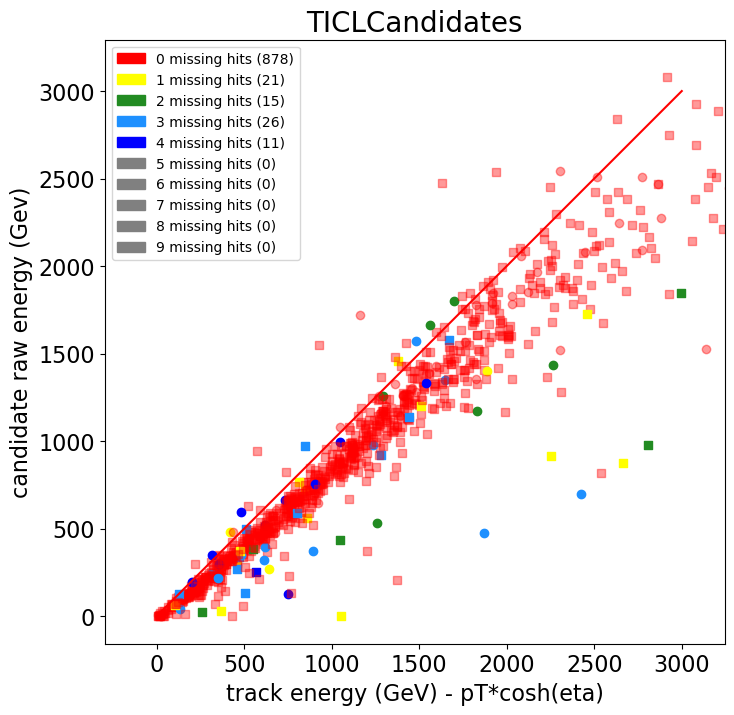

In [78]:
import matplotlib.patches as mpatches
colors = ["red", "yellow", "forestgreen", "dodgerblue", "blue", "grey", "grey", "grey", "grey", "grey"]

counts = np.zeros(10)
plt.figure(figsize=(8,8), dpi=100)
# empty = [0,0]
# with_ts = [0,0]
for tk_in_cand, ts_in_cand, cand_ene, trk_pt, trk_eta, trk_id, trk_miss, trk_nhits in zip(track_in_candidate, tracksters_in_candidate, candidate_raw_energy, track_hgcal_pt,track_hgcal_eta, track_id, track_missing_outer_hits, track_nhits):
    for i, tk in enumerate(tk_in_cand):
        if tk != -1:
            try:
                idx = np.where(trk_id==tk)[0][0]
            except:
                continue
            pt = trk_pt[idx]
            eta = trk_eta[idx]
            missing = trk_miss[idx]
            nhits = trk_nhits[idx]
            if len(ts_in_cand[i])> 0:
                counts[missing] += 1
                plt.scatter(pt*np.cosh(eta), cand_ene[i], c=colors[missing], alpha=alphas[missing], marker=marker[nhits//15])
plt.xlabel("track energy (GeV) - pT*cosh(eta)")
plt.ylabel("candidate raw energy (Gev)")
x = np.linspace(0,3000,100)
plt.plot(x, x, c="red")
plt.axis("equal")
plt.title("TICLCandidates")
patches = []
for i, (count, color) in enumerate(zip(counts, colors)):
    patches.append(mpatches.Patch(color=color, label=str(i) + ' missing hits (' + str(int(count)) + ')'))
plt.legend(handles=patches)
plt.xlim(-50, 3000)
plt.show()

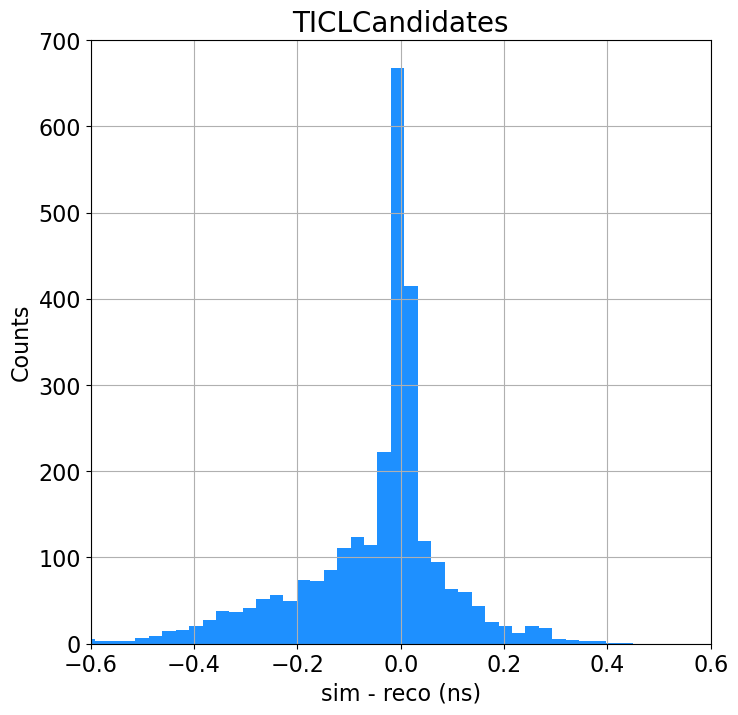

In [79]:
plt.figure(figsize=(8,8), dpi=100)
pull = []
for ev in range(len(candidate_time)):
    sim_time = simTICLCandidate_time[ev][0]
    for reco_time, reco_err in zip(candidate_time[ev], candidate_timeErr[ev]):
#         print(sim_time , reco_time, reco_err)
        if reco_err != -1:
            pull.append((sim_time - reco_time)/1)
pull = np.array(pull)
plt.hist(pull[pull>-1], bins = 50, color="dodgerblue")
plt.xlim(-0.6,0.6)
plt.xlabel("sim - reco (ns)")
plt.ylabel("Counts")
plt.title("TICLCandidates")
plt.grid()
plt.show()

In [80]:
print(f'There are {len(candidate_pdgId)} events in the file')

There are 1000 events in the file


## Compare CP time and TICLCandidate time

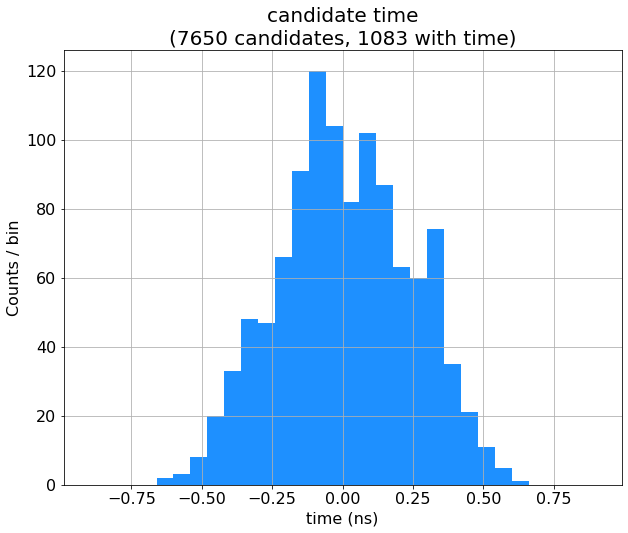

7650


In [134]:
# plt.figure(figsize=(10, 8))
# ncand = len(ak.flatten(candidate_MTD_time0))
# ncandtime = len(ak.flatten(candidate_MTD_time0[candidate_MTD_time0>-99]))
# cc = ak.flatten(candidate_MTD_time0[candidate_MTD_time0>-99])
# cc = cc[cc!=0]
# myhist(ak.flatten(candidate_MTD_time0[candidate_MTD_time0>-99]), range=(-0.9,0.9), bins=30, title=f'candidate time\n({ncand} candidates, {ncandtime} with time, but for {ncandtime-len(cc)} is 0)', xlabel='time (ns)', ylabel='Counts / bin', color='dodgerblue', label="MTD time")
# plt.show()
# print(ncand)
plt.figure(figsize=(10, 8))
ncand = len(ak.flatten(candidate_time))
ncandtime = len(ak.flatten(candidate_time[candidate_timeErr>0]))
cc = ak.flatten(candidate_time[candidate_timeErr>0])
cc = cc[cc!=0]
myhist(ak.flatten(candidate_time[candidate_timeErr>0]), range=(-0.9,0.9), bins=30, title=f'candidate time\n({ncand} candidates, {ncandtime} with time)', xlabel='time (ns)', ylabel='Counts / bin', color='dodgerblue', label="MTD time")
plt.show()
print(ncand)

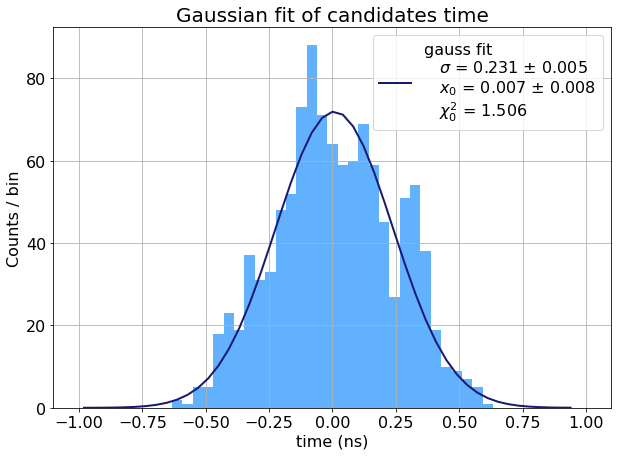

In [135]:
plt.figure(figsize=(10,7))
a = ak.flatten(candidate_time[candidate_timeErr>0])
res, chi2 = gauss_fit_and_plot(a[a<1], init_parms=[1000,0,0.3], label="reco", bins=np.linspace(-1,1,50))
plt.title("Gaussian fit of candidates time")
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

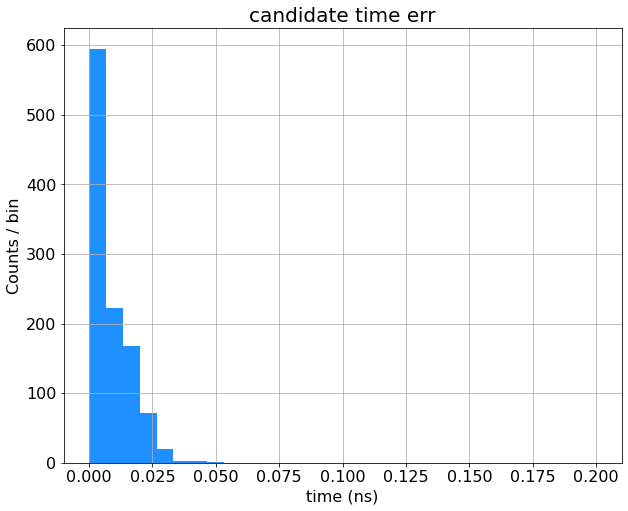

In [136]:
plt.figure(figsize=(10, 8))
myhist(ak.flatten(candidate_timeErr[candidate_time>-99]), range=(0,0.2), bins=30, title='candidate time err', xlabel='time (ns)', ylabel='Counts / bin', color='dodgerblue', label="MTD time")
plt.show()

## candidate time validation

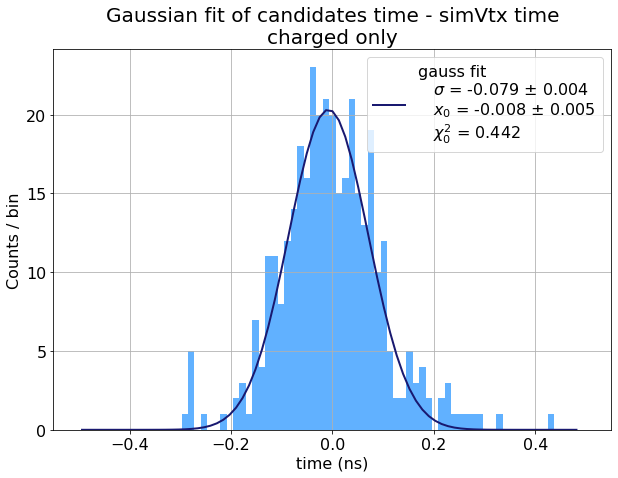

In [137]:
dt_vtx = []
for ev, simTime in enumerate(simTICLCandidate_time):
    simVxt = simTime[0]
    candsPDG = candidate_pdgId[ev]
    cands = candidate_time[ev]
#     cands = candidate_MTD_time0[ev]
    candsErr = candidate_timeErr[ev]
#     print(cands[cands!=-99], "\n", candsPDG[cands!=-99])
    candsPDG = candsPDG[cands!=-99]
    candsErr = candsErr[cands!=-99]
    cands = cands[cands!=-99]
    for cand, candPDG in zip(cands, candsPDG):
        if (abs(candPDG)==11 or abs(candPDG)==211):
            dt_vtx.append(cand - simVxt)
        
plt.figure(figsize=(10,7))
# [np.array(dt_vtx)<1]
res, chi2 = gauss_fit_and_plot(np.array(dt_vtx)[np.array(dt_vtx)>-0.3], init_parms=[175,0,0.03], label="reco", bins=np.linspace(-0.5,0.5, 80))
plt.title("Gaussian fit of candidates time - simVtx time\ncharged only")
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

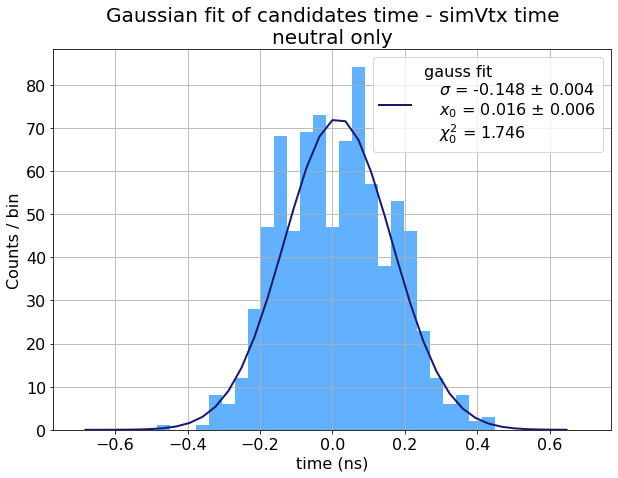

In [138]:
dt_vtx = []
for ev, simTime in enumerate(simTICLCandidate_time):
    simVxt = simTime[0]
    candsPDG = candidate_pdgId[ev]
    cands = candidate_time[ev]
#     cands = candidate_MTD_time0[ev]
    candsErr = candidate_timeErr[ev]
    ts_in_cand = tracksters_in_candidate[ev]
#     ts_time = tracksters_vt[ev]
#     print(cands[cands!=-99], "\n", candsPDG[cands!=-99])
    candsPDG = candsPDG[cands!=-99]
    candsErr = candsErr[cands!=-99]
    cands = cands[cands!=-99]
    for cand, candPDG, ts in zip(cands, candsPDG, ts_in_cand):
        nLCmax = 0
        if (abs(candPDG)==130 or abs(candPDG)==22):
            ####
            # THIS is done to select only candidates with at least one tsMerged with > 7 LCs !
#             for tidx in ts:
# #                 print(ts_time[tidx])
#                 if len(ts_time[tidx])> nLCmax:
#                     nLCmax = len(ts_time[tidx])
# #             print("--",nLCmax,"--")
#             if nLCmax <= 7:
#                 continue
            ####
            dt_vtx.append(cand - simVxt)
#         print("---")
        
plt.figure(figsize=(10,7))
# [np.array(dt_vtx)<1]
res, chi2 = gauss_fit_and_plot(np.array(dt_vtx)[np.array(dt_vtx)<1], init_parms=[700,0,0.1], label="reco", bins=np.linspace(-0.7, 0.7, 40))
plt.title("Gaussian fit of candidates time - simVtx time\nneutral only")
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

## trackster time validation

In [139]:
## calcolo in vari modi che voglio il tmempo del trackster e poi propago sul tempo al boundary (c - retta) e vedo
## ha senso minimizzare la risoluzione e non la media? per il bias di c-retta
TIME = SC_CALO_time # ak.Array(time_all) #
deltaT = TIME[SC_boundary_time!=-99] - SC_boundary_time[SC_boundary_time!=-99]
deltaS = distance(SC_boundx[SC_boundary_time!=-99], SC_boundy[SC_boundary_time!=-99], SC_boundz[SC_boundary_time!=-99], 
                  SC_bx[SC_boundary_time!=-99], SC_by[SC_boundary_time!=-99], SC_bz[SC_boundary_time!=-99])
results = deltaT - deltaS / C
err = SC_CALO_timeErr #(?)

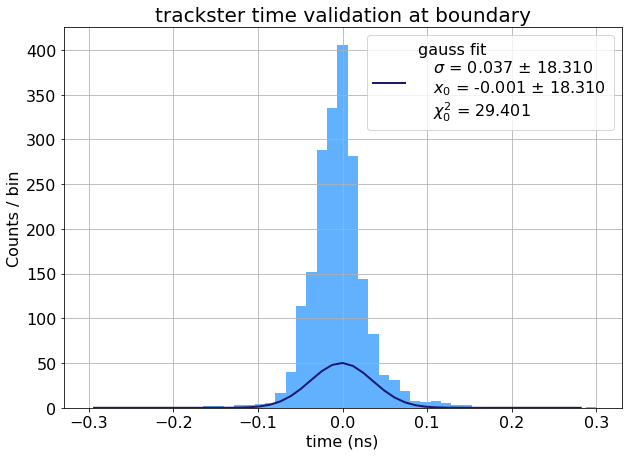

In [118]:
plt.figure(figsize=(10,7))
resu = ak.flatten(results[results>-99]) #np.array(time_all)[np.array(time_all)>-99]
res, chi2 = gauss_fit_and_plot(resu, init_parms=[30,0,0.03], label="reco", bins=np.linspace(-0.3,0.3,50))
#plt.hist(resu)
plt.title("trackster time validation at boundary")
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

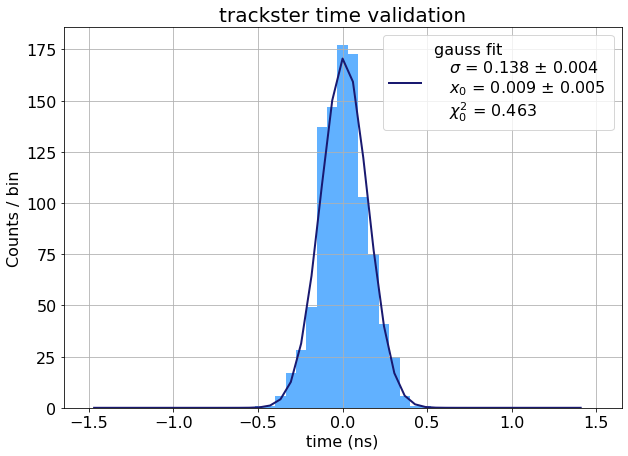

In [91]:
TIME = CP_CALO_time # ak.Array(time_all) #
deltaT = TIME[CP_CALO_time!=-99] - CP_boundary_time[CP_CALO_time!=-99]
deltaS = distance(0,0,0, 
                  CP_bx[CP_CALO_time!=-99], CP_by[CP_CALO_time!=-99], CP_bz[CP_CALO_time!=-99])
results = deltaT - deltaS / C

plt.figure(figsize=(10,7))
resu = ak.flatten(results[results>-99])
res, chi2 = gauss_fit_and_plot(resu, init_parms=[30,0,0.03], label="reco", bins=np.linspace(-1.5,1.5,50))
#plt.hist(resu)
plt.title("trackster time validation at origin")
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

## track linking

In [92]:
for ev in range(len(track_id)):
    if len(track_id[ev])>1:
        print("More than one track in the event", ev)
        print(simTICLCandidate_track_in_candidate[ev], ak.sum(simToReco_en[ev]), track_id[ev], ak.sum(track_hgcal_pt[ev]*np.cosh(track_hgcal_eta[ev])))
        if ak.count((tracksters_in_candidate[ev])[(track_in_candidate[ev])!=-1]):
            print("  track linked with candidate", (track_in_candidate[ev])[(track_in_candidate[ev])!=-1], (tracksters_in_candidate[ev])[(track_in_candidate[ev])!=-1])
        else:
            print("  no track linked with candidate")

More than one track in the event 21
[-1] 727.9536133046349 [0, 1, 2] 5422.1606
  track linked with candidate [0, 1, 2] [[0], [], []]
More than one track in the event 59
[-1] 1354.0345990797505 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] 1793.5865
  track linked with candidate [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] [[], [], [], [], [0], [], [], [], [], [], [], [], [], [], [], [], []]
More than one track in the event 60
[-1] 855.790929203712 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 1057.4044
  track linked with candidate [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [[], [], [], [0], [], [], [1], [], [2], [], [3], []]
More than one track in the event 65
[-1] 707.6273255078122 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 387.132
  track linked with candidate [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [[0], [], [], [1], [], [], [], [], [], [], []]
More than one track in the event 73
[-1] 749.6678491702769 [0, 1, 2, 3, 4, 5, 6] 598.67346
  no track linked with candidate
More than on

In [93]:
# den = []
more_1_track = []
more_1_track_sum = []
one_track_linked = []
one_track_not_linked = []

for tk_pt, tk_id, ts_in_cand, tk_in_cand in zip(track_pt, track_id, tracksters_in_candidate, track_in_candidate):
    # den.append()
    if len(tk_pt)==0:
        print("no reco tracks")
    elif len(tk_pt)==1:
        if ak.count(ts_in_cand[tk_in_cand==tk_id]):
            one_track_linked.append(tk_pt)
        else:
            one_track_not_linked.append(tk_pt)
    else:
        more_1_track.append(tk_pt)
        more_1_track_sum.append(ak.sum(tk_pt))

no reco tracks


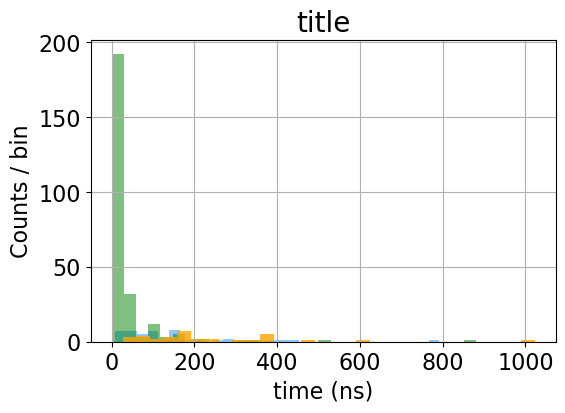

In [94]:
plt.figure(dpi=100)
#myhist(one_track_linked, color="red", alpha=0.5)
myhist(one_track_not_linked, alpha=0.5)
myhist(ak.flatten(more_1_track), color="green", alpha=0.5)
myhist(more_1_track_sum, color="orange", alpha=0.8)